# Categorical classification with transfer learning using VGG19
This will classify images into multiple categories: metal cans, plastic bag, plastic debris, etc, or 'Background', which is the category for clean images

In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tqdm import tqdm
import requests
from io import BytesIO

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
working_dir = '/content/drive/MyDrive/Wagon/deep_dive_data/'
images_dir = working_dir + 'preprocessed/512x512/cropped'

##Load Data

In [7]:
def load_data_with_keras():
    data_dir = '/content/drive/MyDrive/Wagon/deep_dive_data/preprocessed/512x512/cropped'

    batch_size = 32
    img_height = 256
    img_width = 256

    # prepare train set
    train_ds = image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        label_mode='categorical',
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

    class_names = train_ds.class_names
    print(class_names)


    # prepare val set
    val_ds = image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        label_mode='categorical',
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

    return train_ds, val_ds, class_names


In [8]:
train_ds, val_ds, class_names = load_data_with_keras()

Found 1457 files belonging to 15 classes.
Using 1166 files for training.
['Backgrounds', 'Bottle', 'Can', 'Car_Bumper', 'Fishing_Net', 'Glove', 'Metal_Debris', 'Packaging_Bag', 'Pipe', 'Plastic_Bag', 'Plastic_Debris', 'Rope', 'Squared_Can', 'Towel', 'Wood']
Found 1457 files belonging to 15 classes.
Using 291 files for validation.


### Verifications

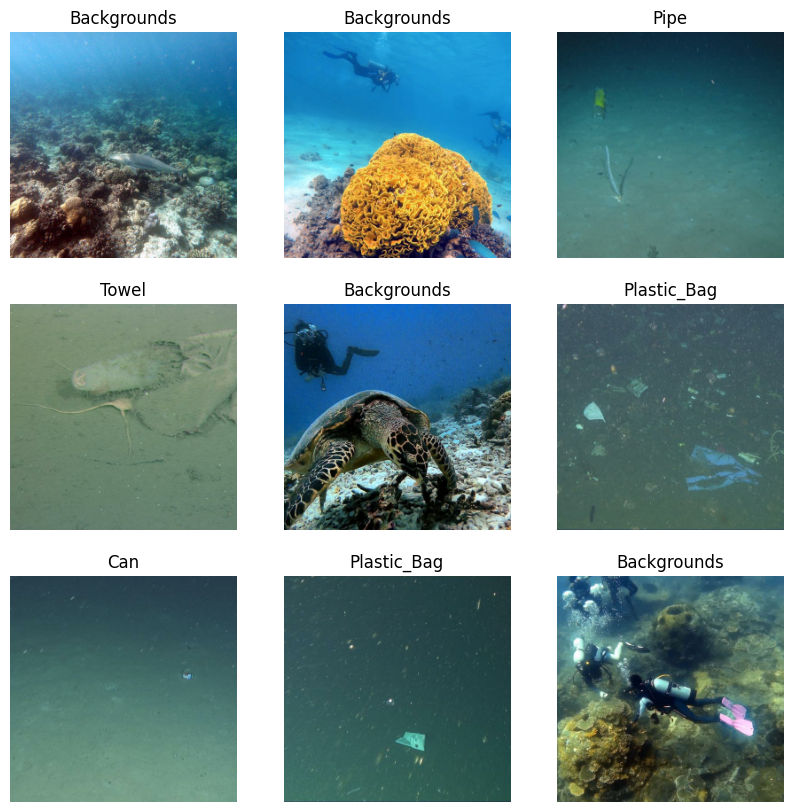

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Get the index of the '1' in the one-hot encoded label
        label_index = np.argmax(labels[i])

        plt.title(class_names[label_index])
        plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 17)


In [ ]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 17)


## Create model

In [10]:
def load_model():
    shape = None
    for images, labels in train_ds.take(1):
        # Access the first image
        first_image = images[0]
        shape = first_image.shape

    model = VGG19(weights="imagenet", include_top=False, input_shape=shape)

    #for layer in model.layers[-4:]:
    #    layer.trainable = True

    return model

In [11]:
def set_nontrainable_layers(model):
    model.trainable = False

    return model

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomRotation(0.5),
  layers.RandomRotation(0.7),
])

In [13]:
def add_last_layers(model, class_names):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    data_augmentation,
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    #batch_norm_layer = layers.BatchNormalization()
    dense_layer = layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.001))
    dense_layer2 = layers.Dense(200, activation='relu')
    #dense_layer = layers.Dense(500, activation='relu')
    #dropout_layer = layers.Dropout(0.3)
    prediction_layer = layers.Dense(len(class_names), activation='softmax')


    model = models.Sequential([
        model,
        flatten_layer,
        #batch_norm_layer,
        dense_layer,
        dense_layer2,
        #dropout_layer,
        prediction_layer
    ])

    return model

In [14]:
def build_model(class_names):
    model = load_model()
    model = add_last_layers(model, class_names)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', tf.keras.metrics.F1Score()])
    return model

In [15]:
model = build_model(class_names)
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 500)               16384500  
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dense_2 (Dense)             (None, 15)                3015      
                                                                 
Total params: 36512099 (139.28 MB)
Trainable params: 16487715 (62.90 MB)
Non-trainable params: 20024384 (76.39 MB)
______

In [16]:
def preprocess_dataset(images, labels):
    return preprocess_input(images), labels

In [17]:
def preprocess_labels(image, label):
    return image, to_categorical(label, num_classes=17)

In [18]:
train_ds = train_ds.map(preprocess_dataset)
val_ds = val_ds.map(preprocess_dataset)

In [19]:
es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=[es])

Epoch 1/50
37/37 [==============================] - 111s 3s/step - loss: 4.5049 - accuracy: 0.3851 - f1_score: 0.1431 - val_loss: 3.4489 - val_accuracy: 0.4399 - val_f1_score: 0.1737
Epoch 2/50
37/37 [==============================] - 16s 390ms/step - loss: 1.3262 - accuracy: 0.8954 - f1_score: 0.7898 - val_loss: 3.4425 - val_accuracy: 0.5017 - val_f1_score: 0.2152
Epoch 3/50
37/37 [==============================] - 13s 310ms/step - loss: 1.0555 - accuracy: 0.9794 - f1_score: 0.9085 - val_loss: 3.5979 - val_accuracy: 0.5017 - val_f1_score: 0.2144
Epoch 4/50
37/37 [==============================] - 17s 428ms/step - loss: 0.9848 - accuracy: 0.9957 - f1_score: 0.9286 - val_loss: 3.6859 - val_accuracy: 0.4983 - val_f1_score: 0.2124
Epoch 5/50
37/37 [==============================] - 17s 430ms/step - loss: 0.9378 - accuracy: 0.9991 - f1_score: 0.9321 - val_loss: 3.7022 - val_accuracy: 0.4983 - val_f1_score: 0.2029
Epoch 6/50
37/37 [==============================] - 17s 431ms/step - loss: 0.

In [44]:
def load_and_preprocess_image(img_path):
    # Download the image
    response = requests.get(img_path)
    img = Image.open(BytesIO(response.content))

    # Resize the image to match the model's expected input size
    img = img.resize((256, 256))
    plt.imshow(img)
    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Expand dimensions to match the model's expected input format
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    return img_array

1/1 [==============================] - 0s 26ms/step
Backgrounds


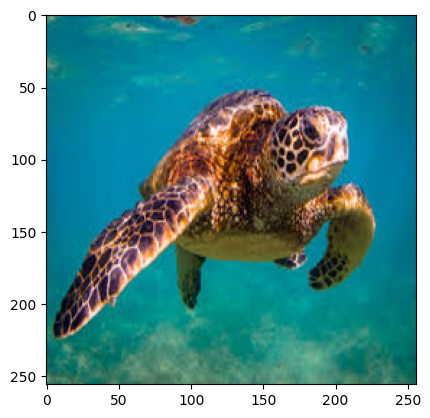

In [59]:
test_img = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSc4w6Ey0a05Et7my42NDnAn9CTvbrFx8CSmA&usqp=CAU'

# Predict
predictions = model.predict(load_and_preprocess_image(test_img))

# Process predictions
predicted_class = np.argmax(predictions, axis=1)
print(class_names[int(predicted_class)])